# Make changes to already generated h5 datasets
This notebook can be used to edit a h5 file instead of redownloading all images from Flickr using generate.py when the only change is the model used for aesthetics scoring, embedding, etc

In [1]:
import os
import json
import h5py
import numpy as np
from io import BytesIO
from PIL import Image

## Scoring

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3"
scoring_path = os.path.abspath("../scoring/NIMA") 
weights_file = os.path.join(scoring_path, "models/MobileNet/weights_mobilenet_aesthetic_0.07.hdf5")
base_model_name = "MobileNet"
sys.path.insert(1, scoring_path)
from src.evaluater.predict import process_samples

In [9]:
src_file = "paris_1000_test.h5"
tgt_file = "paris_1000_test_modified.h5"
with h5py.File(src_file, "r") as src:
    # Batch forward into the scoring model
    samples = list({"id": id, "image":Image.open(BytesIO(src[id]["binary"][...])).convert("RGB")} for id in src.keys())
    print("Predict on samples...")
    process_samples(base_model_name, weights_file, samples)
    print("Done, start writing in new h5 file...")
    with h5py.File(tgt_file, "w") as tgt:
        for i, id in enumerate(src.keys()):
            # Get data
            p = src[id]
            metadata, binary, embedding = p.attrs["metadata"], p["binary"][...], p["embedding"][...]
            metadata = json.loads(metadata)
            image = Image.open(BytesIO(binary)).convert("RGB")
            
            # Predict score
            aesthetic_score = list(filter(lambda s: s["id"] == id, samples)).pop()["mean_score_prediction"]
            aesthetic_score = samples[i]["mean_score_prediction"]
            metadata["aesthetic_score"] = aesthetic_score

            # Insert into new h5 file
            g = tgt.create_group(id)
            g.create_dataset("binary", data=binary)
            g.create_dataset("embedding", data=embedding)
            g.attrs["metadata"] = json.dumps(metadata)

        print("Done: source has", len(src.keys()), "keys, target has", len(tgt.keys()))

Predict on samples...
Done, start writing in new h5 file...
Done: source has 999 keys, target has 999


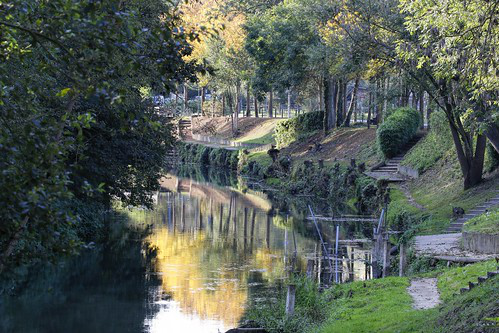

4.598831067307401


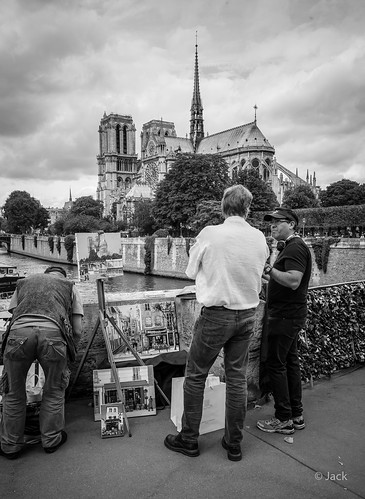

4.597947429072519


In [11]:
# Check it worked
with h5py.File(tgt_file, "r") as src:
    p = src[list(src.keys()).pop(0)]
    metadata = json.loads(p.attrs["metadata"])
    display(Image.open(BytesIO(p["binary"][...])))
    print(metadata["aesthetic_score"])
    p = src[list(src.keys()).pop(1)]
    metadata = json.loads(p.attrs["metadata"])
    display(Image.open(BytesIO(p["binary"][...])))
    print(metadata["aesthetic_score"])